Are animated movies becoming more popular?

Different indicators:
- more movie releases
- increased revenue 

In [88]:
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9) 

Populating the interactive namespace from numpy and matplotlib


In [2]:
# https://stackoverflow.com/questions/25373167/multithreading-in-python-beautifulsoup-scraping-doesnt-speed-up-at-all
# https://stackoverflow.com/questions/38861829/how-do-i-implement-a-progress-bar
# https://github.com/alexanderkuk/log-progress
from bs4 import BeautifulSoup
from urllib2 import urlopen
import urllib
import re
from difflib import SequenceMatcher
import json

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

In [3]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [4]:
# https://www.boxofficemojo.com/genres/chart/?view=main&sort=gross&order=DESC&pagenum=1&id=animation.htm
# https://www.boxofficemojo.com/genres/chart/?view=main&sort=gross&order=DESC&pagenum=2&id=animation.htm
# https://www.boxofficemojo.com/genres/chart/?view=main&sort=gross&order=DESC&pagenum=3&id=animation.htmb

base_url = "https://www.boxofficemojo.com/genres/chart/?view=main&sort=gross&order=DESC&pagenum={index}&id=animation.htm"
url = base_url.format(**{"index": 1})
soup = BeautifulSoup(urlopen(url).read(), 'lxml')
movies = soup.findAll('a', href=re.compile("/movies/?"))

In [5]:
def extract_movie_details(element):
    """
    # Extract the following data from the given html5 element passed along from the 
    # 1. Rank
    # 2. Title
    # 3. Studio
    # 4. Lifetime Gross (US only)
    # 5. Theaters
    # 6. Opening 
    # 7. Theaters
    # 8. Date
    # 9. URL
    """
    info = []
    # ensure we have the right hierarchy
    if element.parent.parent.parent.name == 'tr':    
        tdc = element.parent.parent.parent.findChildren('td')
        if len(tdc) == 8:            
            for i in range(len(tdc)):
                if i == 1:
                    info.append(str(tdc[i].font.a.b.string))
                elif i == 3 or i == 5:
                    info.append(str(tdc[i].string)[1:].replace(',', ''))
                elif i == 4 or i == 6:
                    info.append(str(tdc[i].string).replace(',', ''))
                else:
                    info.append(str(tdc[i].string))
                
            info.append(element.get('href'))
    return info

extract_movie_details(movies[3])

['3',
 'Shrek 2',
 'DW',
 '441226247',
 '4223',
 '108037878',
 '4163',
 '5/19/04',
 '/movies/?id=shrek2.htm']

In [11]:
def get_page_content(index=1):
    """
    Load up an individual summary page of the animation genre
    """
    base_url = "https://www.boxofficemojo.com/genres/chart/?view=main&sort=gross&order=DESC&pagenum={index}&id=animation.htm"
    url = base_url.format(**{"index": index})
    soup = BeautifulSoup(urlopen(url).read(), 'lxml')
    movies = soup.findAll('a', href=re.compile("/movies/?"))
    
    mdata = []
    for movie in movies:
        info = extract_movie_details(movie)
        if info:
            mdata.append(info)
            
    return mdata

len(get_page_content(5))

80

In [17]:
amdata = []
for index in log_progress([i for i in range(1, 6)], every=1):
    amdata.extend(get_page_content(index=index))
len(amdata)

480

In [18]:
def get_movie_page_content(url_info):
    """
    Extract the following data from the boxofficemojo movie title page
    # 0 Gross: $441,226,247
    # 1 Distributor: DreamWorks
    # 2 Release Date: May 19, 2004
    # 3 Genre: Animation
    # 4 Runtime: 1 hrs. 33 min.
    # 5 MPAA Rating: PG
    # 6 Production Budget: $150 million
    # 7 Worldwide lifetime gross: $968,483,777
    """
    link=url_info[-1]
    title=url_info[1]
    
    url = 'https://www.boxofficemojo.com'+link
#     print 'loading {}'.format(url)
    soup = BeautifulSoup(urlopen(url).read(), 'lxml')
    tables = soup.findAll("table")
    
    data = {}
    c = 0
    url = 'https://www.boxofficemojo.com'+link
    soup = BeautifulSoup(urlopen(url).read(), 'lxml')
    tables = soup.findAll("table")
    for table in tables:
        if table.parent.name == 'td':
            if similar(table.parent.font.getText(), title) > 0.9:
                if table.tr.td.center:
                    for item in table.tr.td.center.table.findChildren('tr'):
                        for child in item.findChildren('td'):
                            text = child.getText()
                            if 'Domestic Total Gross' in text:
                                data['DomesticGross'] = int(child.b.string[1:].replace(',', ''))                                
                            
                            if 'Distributor' in text:
                                data['Distributor'] = child.b.string
                                
                            if 'Release Date' in text:
                                data['ReleaseDate'] = child.b.string
                                
                            if 'Genre' in text:
                                data['Genre'] = child.b.string
                                
                            if 'Runtime' in text:                            
                                data['Runtime'] = child.b.string
                            
                            if 'MPAA Rating' in text:
                                data['Rating'] = child.b.string
                                
                            if 'Production Budget' in text:
                                value = child.b.string
                                if child.b.string != 'N/A':
                                    if 'million' in child.b.string:
                                        value = int(float(child.b.string[1:].split(' ')[0]) * 1000000)
                                    else:
                                        value = int(child.b.string[1:].replace(',', ''))
                                data['ProductionBudget'] = value
                                        
    foundGross = False
    divs = soup.findAll("div", {"class": "mp_box_tab"})    
    for div in divs:
        if div.string == 'Total Lifetime Grosses':
            trs = div.parent.findChildren('tr')
            if trs:
                tds = trs[-1].findChildren('td')
                if tds and len(tds) > 2:
                    foundGross = True
                    data['WorldGross'] = int(tds[1].b.string[1:].replace(',', ''))
                    
    if not foundGross:
        data['WorldGross'] = 'N/A'
    return data

index = 1
get_movie_page_content(amdata[index])

{'Distributor': u'Buena Vista',
 'DomesticGross': 486295561,
 'Genre': u'Animation',
 'ProductionBudget': u'N/A',
 'Rating': u'PG',
 'ReleaseDate': u'June 17, 2016',
 'Runtime': u'1 hrs. 43 min.',
 'WorldGross': 1028570889}

In [19]:
adddata = []
for movie in log_progress(amdata, every=1):
    res = get_movie_page_content(movie)
    adddata.append(res)

In [20]:
def find_wiki_page(query):
    url = 'https://en.wikipedia.org/w/api.php?action=opensearch&search={}&limit=1&namespace=0&format=json'.format(urllib.quote_plus(query))
    response = urlopen(url)
    url_data = json.loads(response.read())    
    if url_data:
        if len(url_data) == 4:            
            if len(url_data[3]) == 1:
                return url_data[3][0]
            else:
                # none or multiple results
                pass
    response.close()

find_wiki_page('incredibles 2')

u'https://en.wikipedia.org/wiki/Incredibles_2'

In [21]:
def get_num(x):    
    # remove any special? characters
    x = x.encode('ascii', 'replace')

    if x[0] == '?':
        pieces = x.split('(')
        if len(pieces) == 1:
            x = x[1:]
        else:
            x = x.split('(')[1]
    
    # 'MX$100.7 million(US$5.4 million)'
    if x[:2] == 'MX':
        x = x.split('(')[1]
    
    # strip off any (details)
    x = x.split('(')[0]
        
    if x[:3] == 'US ':
        x = x[3:]
        
    if x[:2] == '< ' or x[:2] == 'US':
        x = x[2:]
                            
    if x[0] == '$':
        x = x[1:]            
        
    result = ''
    for i in x:
        if i.isdigit() or i == '.':
            result += i
        elif i == ',':
            pass
        else:
            break
            
    return result

def get_movie_data_from_wiki(url):
    """
    Get the following data from a movie title wiki page
    {'budget': u'$200 million',
     'country': u'United States',
     'gross': u'$1.121 billion'}
    """
    data = {}
    soup = BeautifulSoup(urlopen(url).read(), 'lxml')
    tables = soup.findAll("table", {"class": "infobox vevent"})
    if not tables:
        return data
    
    for i, tr in enumerate(tables[0].findChildren('tr')):
        if 'Country' in tr.getText():
            country = tr.td.getText().replace('\n', '')
            if '[' in country:
                country = country.split('[')[0]
            data['country'] = country
        
        if 'Budget' in tr.getText():
            text = tr.td.getText().replace('\n', '')
            if '[' in text:
                text = text.split('[')[0]
            
            value = get_num(text)
            if 'million' in text:
                budget = int(float(value) * 1000000)
            else:
                budget = int(value)
                
            data['budget'] = budget
            
        if 'Box office' in tr.getText():
            text = tr.td.getText().replace('\n', '')
            if '[' in text:
                text = text.split('[')[0]
                
            value = get_num(text)
            if 'million' in text:
                gross = int(float(value) * 1000000)            
            elif 'billion' in text:
                gross = int(float(value) * 1000000000)            
            else:
                gross = value
            
            data['gross'] = gross
    
    return data
        
url = find_wiki_page('incredibles2')
if url:
    print get_movie_data_from_wiki(url)

{'country': u'United States', 'budget': 200000000, 'gross': 1121000000}


In [22]:
wikidata = []
for movie in log_progress(amdata, every=1):
    reformated = movie[1].lower()
    if reformated[:3] == 'the': # wikipedia doesn't seem to store the with the title of the movie
        reformated = reformated[3:]
    reformated = reformated.split('(')[0] # remove any (details) from the title
        
    url = find_wiki_page(reformated)
    res = {}
    if url:
        try:
            res = get_movie_data_from_wiki(url)
        except Exception as e:
            pass
    wikidata.append(res)
    
wikidata

[{'budget': 200000000, 'country': u'United States', 'gross': 1121000000},
 {'budget': 175000000, 'country': u'United States', 'gross': 1028999999},
 {'budget': 150000000, 'country': u'United States', 'gross': 919800000},
 {'budget': 45000000, 'country': u'United States', 'gross': 968500000},
 {'budget': 200000000, 'country': u'United States', 'gross': 1067000000},
 {},
 {'budget': 94000000, 'country': u'United States', 'gross': 940300000},
 {'budget': 75000000, 'country': u'United States', 'gross': 875500000},
 {'budget': 76000000, 'country': u'United States', 'gross': 970800000},
 {},
 {'budget': 150000000, 'country': u'United States', 'gross': 1024000000},
 {},
 {'budget': 160000000, 'country': u'United States', 'gross': 799000000},
 {},
 {'budget': 115000000, 'country': u'United States', 'gross': 577400000},
 {},
 {'budget': 200000000, 'country': u'United States', 'gross': 744200000},
 {'budget': 60000000, 'country': u'United States', 'gross': 484400000},
 {'budget': 80000000, 'coun

In [60]:
# unify
cdata = []
for xd, dd, wd in zip(adddata, amdata, wikidata):
    info = {}
#     print xd
    # xd - adddata
    # Rating
    info['rating'] = xd['Rating']
    # ProductionBudget
    info['budget'] = xd['ProductionBudget']
    # ReleaseDate
    # Genre
    # Distributor
    info['distributor'] = xd['Distributor']
    #DomesticGross
    if 'DomesticGross' in xd:
        info['domesticGross'] = xd['DomesticGross']    
    # WorldGross
    info['worldGross'] = xd['WorldGross']
    
    # dd - amdata
    # 1. Rank +
    # 2. Title +
    info['title'] = dd[1]
    # 3. Studio
    # 4. Lifetime Gross (US only) +
    # 5. Theaters +
    info['domesticTheaters'] = dd[4]
    # 6. Opening 
    # 7. Theaters
    # 8. Date +
    info['date'] = dd[7]
    # 9. URL
    
    # wd - wikidata
    # budget
    if 'budget' in wd:
        if info['budget'] == 'N/A':
            info['budget'] = wd['budget']
    # country
    if 'country' in wd:
        info['country'] = wd['country']
    
    # gross Worlwide lifetime gross     
    if 'gross' in wd:
        if info['worldGross'] == 'N/A':
            info['worldGross'] = wd['gross']
    
    cdata.append(info)

In [102]:
import pandas as pd
df = pd.DataFrame(cdata)
df.to_csv('data/agg_movie_data.csv', index=False)

In [112]:
df = pd.read_csv('data/agg_movie_data.csv')

In [113]:
df = df[df['date'] != 'N/A']
df['date'] = pd.to_datetime(df['date'])
# remove any movies released in the year 2018
df = df[df['date'] < '2018-01-01']
# remove any movies that were shown in less then 1000 theaters
df.head()

,budget,country,date,distributor,domesticGross,domesticTheaters,rating,title,worldGross
1,175000000.0,United States,2016-06-17,Buena Vista,486295561.0,4305,PG,Finding Dory,1.028571e+09
2,150000000.0,United States,2004-05-19,DreamWorks,441226247.0,4223,PG,Shrek 2,9.198388e+08
3,45000000.0,United States,1994-06-15,Buena Vista,312855561.0,2624,G,The Lion King,9.684838e+08
4,200000000.0,United States,2010-06-18,Buena Vista,415004880.0,4028,G,Toy Story 3,1.066970e+09
5,150000000.0,NaN,2013-11-22,Buena Vista,400738009.0,3742,PG,Frozen,1.276480e+09


In [119]:
df[df['domesticTheaters'] == '-']

,budget,country,date,distributor,domesticGross,domesticTheaters,rating,title,worldGross
132,12000000.0,United States,1981-07-10,Buena Vista,39900000.0,-,G,The Fox and the Hound,63500000.0
134,80000000.0,United States,2000-01-01,Buena Vista,52260454.0,-,G,Fantasia 2000 (IMAX),90900000.0
135,80000000.0,United States,2000-01-01,Buena Vista,8394966.0,-,G,Fantasia 2000 (35mm),90900000.0
251,NaN,NaN,1985-03-22,Atlantic,7660857.0,-,G,He-Man and She-Ra in The Secret of the Sword,NaN
257,NaN,United StatesLuxembourgCanadaJapanFrance,1985-01-18,Atlantic,6565359.0,-,G,Here Come the Littles,6600000.0
279,10000000.0,United States,1987-12-25,New World,3261638.0,-,G,Pinocchio and the Emperor of the Night,3261638.0
283,NaN,FranceUnited States,1986-01-17,Atlantic,2610686.0,-,G,Heathcliff: The Movie,2600000.0
291,NaN,United States,1980-05-30,Paramount,2013193.0,-,G,Bon Voyage Charlie Brown,2000000.0
296,NaN,NaN,1989-07-27,EXP Ent.,1487606.0,-,Unrated,The 2nd Animation Celebration,NaN
301,NaN,NaN,1990-12-21,EXP Ent.,1289551.0,-,Unrated,The 3rd Animation Celebration,NaN


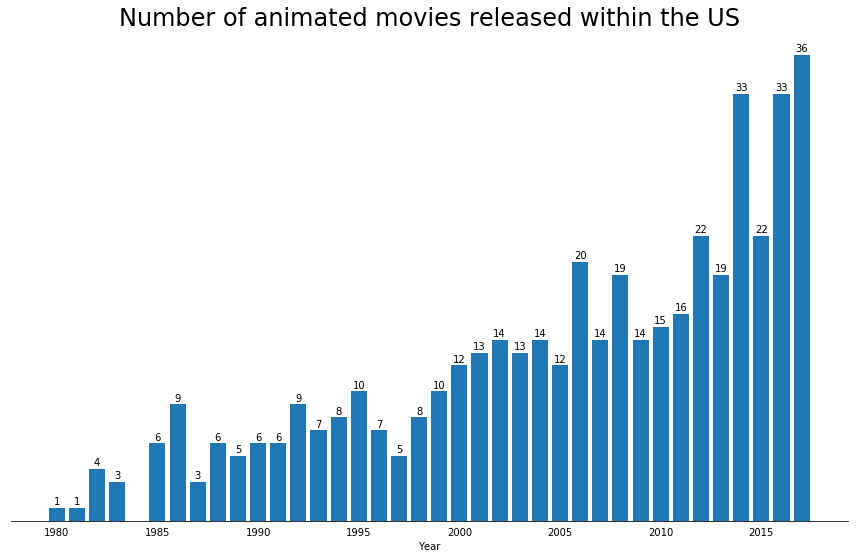

In [114]:
mpy = df.groupby(df.date.dt.year)['date'].count()

fig = pylab.figure()
plt.bar(mpy.index.values, mpy.values)
plt.xlabel('Year')
plt.title('Number of animated movies released within the US', fontsize=24)
ax = fig.add_subplot(1,1,1)
plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='on')
for spine in ['top', 'right', 'left']:
    ax.spines[spine].set_visible(False)
    
for i in range(len(mpy.values)):
    ax.annotate('{}'.format(mpy.values[i]), xy=(mpy.index[i], mpy.values[i]+.25), ha='center')

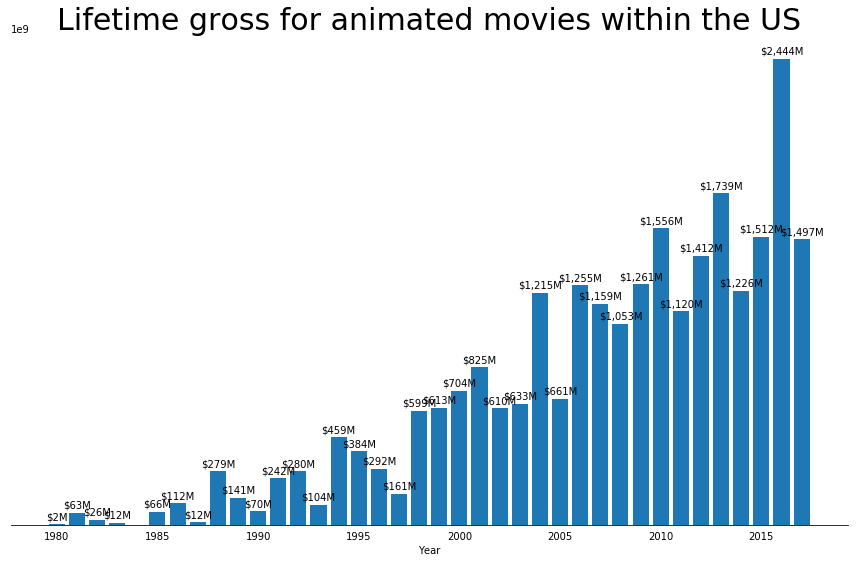

In [14]:
# is this adjusted for inflation?
gpy = pd.DataFrame({'Date':df['Date'], 'Gross': df['Lifetime Gross']})
gpy = gpy[gpy['Gross'] != '/a']
gpy['Gross'] = gpy['Gross'].astype(int64)
rgpy = gpy.groupby(df.Date.dt.year).sum()

fig = pylab.figure()
plt.title('Lifetime gross for animated movies within the US', fontsize=30)
plt.bar(rgpy.index[:-1], rgpy.Gross.values[:-1], width=.8)
plt.xlabel('Year')
ax = fig.add_subplot(1,1,1)
plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='on')

for spine in ['top', 'right', 'left']:
    ax.spines[spine].set_visible(False)
    
for i in range(len(rgpy.Gross.values[:-1])):
    value = rgpy.Gross.values[i] / 1000000
    ax.annotate('${:,}M'.format(value), xy=(rgpy.index[i], rgpy.Gross.values[i] + 25000000), ha='center')

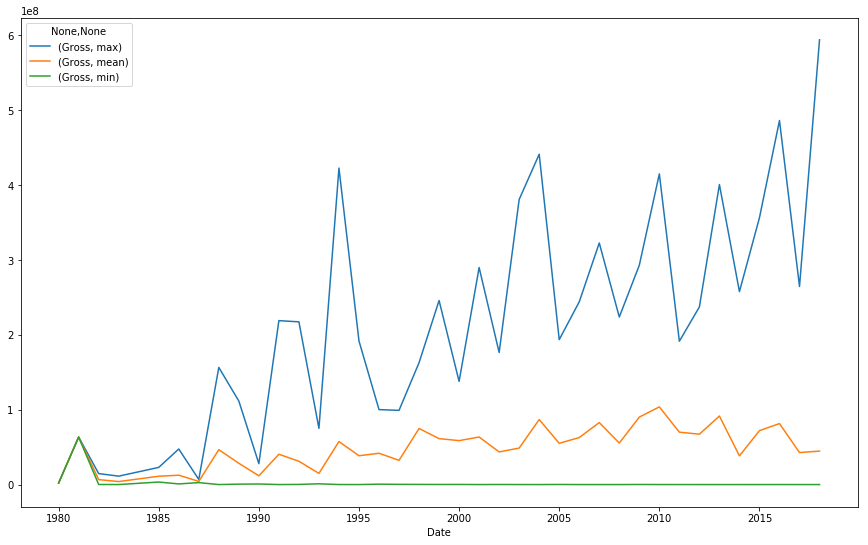

In [40]:
# Min, max and mean gross per year
gpy = pd.DataFrame({'Date':df['Date'], 'Gross': df['Lifetime Gross']})
gpy = gpy[gpy['Gross'] != '/a']
gpy['Gross'] = gpy['Gross'].astype(int64)
gpy.groupby(df.Date.dt.year).agg({'min','max','mean'}).plot()

In [41]:
# Who are the biggest losers and winners?

In [42]:
# What the return on investment ratio?